In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import (
    mean_absolute_error, root_mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from mlxtend.frequent_patterns import apriori, association_rules

Loading the dataset and Basic Preprocessing:
Deleting outliers, Duplicates, Null values

In [2]:
df = pd.read_csv("student-academic-performance.csv")
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.head()

,Gender,HoursStudied/Week,Tutoring,Region,Attendance(%),Parent Education,Exam_Score
0,Male,5.5,No,Urban,72.7,Tertiary,43.5
1,Female,6.8,No,Urban,62.0,Primary,51.7
2,Female,9.7,No,Rural,95.0,Secondary,70.1
5,Female,7.9,No,Urban,73.7,Tertiary,58.8
6,Female,7.6,No,Urban,79.5,Secondary,64.8


One-hot Encoding on: Gender, Tutoring, Region, Parent Education

In [3]:
def exam_class(score):
    if score >= 85:
        return "High"
    elif score >= 60:
        return "Medium"
    else:
        return "Low"

df["ScoreClass"] = df["Exam_Score"].apply(exam_class)
class_map = {"Low": 0, "Medium": 1, "High": 2}
df["ScoreClassNum"] = df["ScoreClass"].map(class_map)

categoricals = ["Gender", "Tutoring", "Region", "Parent Education"]
df_encoded = pd.get_dummies(df, columns=categoricals, drop_first=True)

X = df_encoded.drop(["Exam_Score", "ScoreClass", "ScoreClassNum"], axis=1)
y_reg = df_encoded["Exam_Score"]
y_clf = df_encoded["ScoreClassNum"]

X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Regression:

c:\Users\ELECOMP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

c:\Users\ELECOMP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

c:\Users\ELECOMP\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



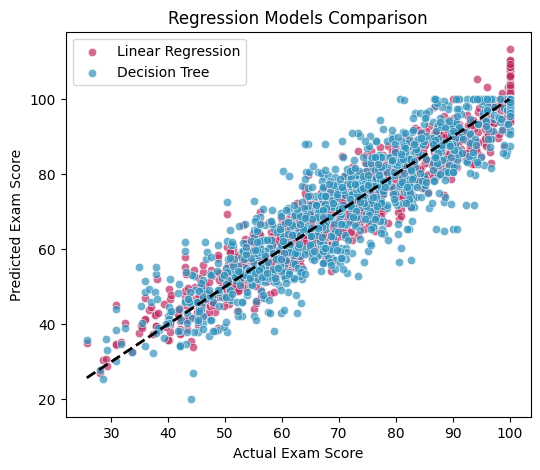

In [4]:
def evaluate_regression_models_plotly(models, X_train, X_test, y_train, y_test):
    results = []
    y_preds = {} 

    for name, model, use_scaled in models:
        if use_scaled:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        y_preds[name] = y_pred

        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append([name, round(mae, 2), round(rmse, 2), round(r2, 3)])
    
    df_results = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R²"])

    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(df_results.columns),
            fill_color='#004c6d',
            align='center',
            font=dict(color='white', size=14),
            height=35
        ),
        cells=dict(
            values=[df_results[col] for col in df_results.columns],
            fill_color=[['#f0f8ff' if i%2==0 else '#e6f3ff' for i in range(len(df_results))]],
            align='center',
            font=dict(color='black', size=12),
            height=30
        )
    )])

    fig.update_layout(width=600, height=300, margin=dict(l=0, r=0, t=30, b=0))
    fig.show()

    return y_preds 

regression_models = [
    ("Linear Regression", LinearRegression(), True),
    ("Decision Tree Regressor", DecisionTreeRegressor(random_state=42), False) 
]

y_preds = evaluate_regression_models_plotly(
    regression_models, 
    X_train, X_test, 
    y_reg_train, y_reg_test
)

y_pred_lin = y_preds["Linear Regression"]
y_pred_tree = y_preds["Decision Tree Regressor"]

plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_reg_test, y=y_pred_lin, color="#be2d62", label="Linear Regression", alpha=0.7)
sns.scatterplot(x=y_reg_test, y=y_pred_tree, color="#3092bc", label="Decision Tree", alpha=0.7)
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()],
         'k--', lw=2)
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Regression Models Comparison")
plt.legend()
plt.show()


Classification

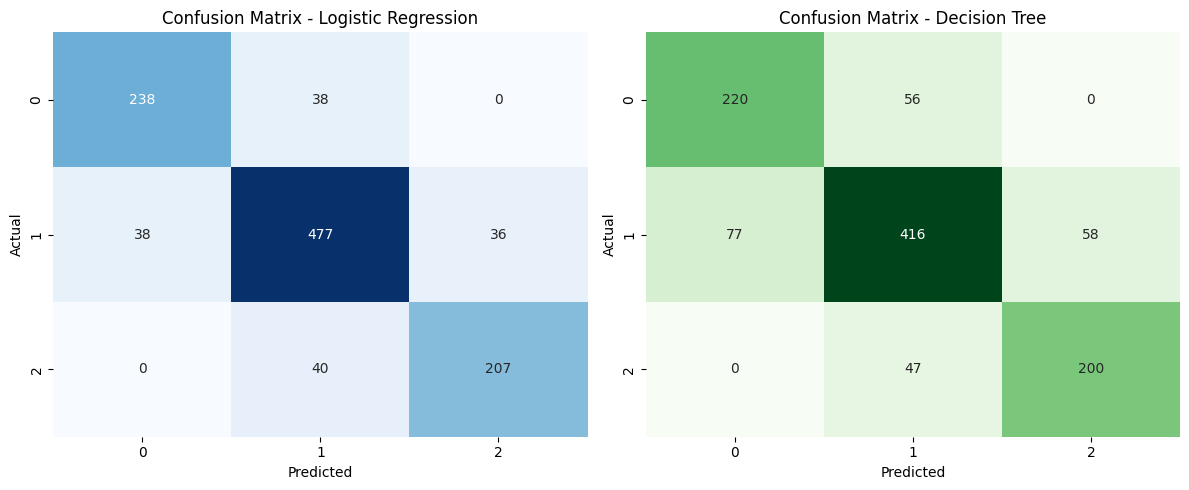

In [5]:
log_reg = LogisticRegression(max_iter=1000, multi_class='auto', solver='lbfgs')
log_reg.fit(X_train_scaled, y_clf_train)
y_pred_log = log_reg.predict(X_test_scaled)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_clf_train)  
y_pred_tree_clf = tree_clf.predict(X_test)

def evaluate_classification_models_plotly(models, X_train, X_test, y_train, y_test):
    results = []
    for name, model, use_scaled, average_type in models:
        if use_scaled:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average=average_type)
        recall = recall_score(y_test, y_pred, average=average_type)
        f1 = f1_score(y_test, y_pred, average=average_type)
        
        results.append([
            name, round(acc, 3), round(precision, 3), round(recall, 3), round(f1, 3)
        ])
    
    df_results = pd.DataFrame(results, 
                               columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])

    fig = go.Figure(data=[go.Table(
        header=dict(
            values=list(df_results.columns),
            fill_color="#104054",
            align='center',
            font=dict(color='white', size=14),
            height=35
        ),
        cells=dict(
            values=[df_results[col] for col in df_results.columns],
            fill_color=[['#f0f8ff' if i % 2 == 0 else '#e6f3ff' 
                         for i in range(len(df_results))]],
            align='center',
            font=dict(color='black', size=12),
            height=30
        )
    )])

    fig.update_layout(
        width=750,
        height=320,
        margin=dict(l=0, r=0, t=30, b=0)
    )

    fig.show()

classification_models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000), True, "weighted"),
    ("Decision Tree Classifier", DecisionTreeClassifier(random_state=42), False, "weighted")
]

evaluate_classification_models_plotly(classification_models, 
                                      X_train, X_test, y_clf_train, y_clf_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_clf_test, y_pred_log), annot=True, fmt="d",
            cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Confusion Matrix - Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_clf_test, y_pred_tree_clf), annot=True, fmt="d",
            cmap="Greens", cbar=False, ax=axes[1])
axes[1].set_title("Confusion Matrix - Decision Tree")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


Clustering

In [6]:
def kmeans_clustering_auto(X, scale=True, max_k=10, random_state=42):
    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X.values

    Ks = list(range(2, max_k + 1))
    inertia_list = []
    for k in Ks:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        km.fit(X_scaled)
        inertia_list.append(km.inertia_)

    p1 = np.array([Ks[0], inertia_list[0]])
    p2 = np.array([Ks[-1], inertia_list[-1]])
    distances = []
    for i in range(len(Ks)):
        p = np.array([Ks[i], inertia_list[i]])
        dist = np.abs(np.cross(p2 - p1, p1 - p)) / np.linalg.norm(p2 - p1)
        distances.append(dist)
    k_optimal = Ks[int(np.argmax(distances))]

    fig_elbow = go.Figure()
    fig_elbow.add_trace(go.Scatter(
        x=Ks,
        y=inertia_list,
        mode='lines+markers',
        marker=dict(color='#1f77b4', size=8),
        line=dict(width=2),
        name="Inertia"
    ))
    fig_elbow.add_vline(
        x=k_optimal,
        line=dict(color='red', dash='dash'),
        annotation_text=f"Optimal k = {k_optimal}",
        annotation_position="top right"
    )
    fig_elbow.update_layout(
        title="Elbow Method for Optimal K",
        template="plotly_white",
        xaxis_title="Number of Clusters (k)",
        yaxis_title="Inertia",
        width=700,
        height=450
    )
    fig_elbow.show()

    kmeans = KMeans(n_clusters=k_optimal, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    if scale:
        centers = scaler.inverse_transform(kmeans.cluster_centers_)
    else:
        centers = kmeans.cluster_centers_


    df_plot = X.copy().reset_index(drop=True)
    df_plot["Cluster"] = labels.astype(str)

    fig_clusters = px.scatter(
        df_plot,
        x=X.columns[0],
        y=X.columns[1],
        color="Cluster",
        symbol="Cluster",
        opacity=0.8,
        color_discrete_sequence=px.colors.qualitative.Set2,
        title=f"KMeans Clustering (k={k_optimal})",
        template="plotly_white"
    )
    centers_rounded = np.round(centers, 2)
    fig_clusters.add_trace(go.Scatter(
        x=centers_rounded[:, 0],
        y=centers_rounded[:, 1],
        mode='markers',
        marker=dict(color='gold', size=14, symbol='x', line=dict(width=2, color='black')),
        name='Centers',
        hovertemplate='Center: (%{x:.2f}, %{y:.2f})<extra></extra>'
    ))
    fig_clusters.update_layout(width=720, height=480)
    fig_clusters.show()

    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    eval_df = pd.DataFrame({
        "Cluster": range(k_optimal),
        "Size": cluster_sizes.values,
    })

    eval_df["Size"] = eval_df["Size"].astype(int)

    fig_table = go.Figure(data=[go.Table(
        header=dict(
            values=list(eval_df.columns),
            fill_color='#004c6d',
            align='center',
            font=dict(color='white', size=14),
            height=35
        ),
        cells=dict(
            values=[eval_df[col] for col in eval_df.columns],
            fill_color=[['#f0f8ff' if i % 2 == 0 else '#e6f3ff'
                         for i in range(len(eval_df))]],
            align='center',
            font=dict(color='black', size=12),
            height=30
        )
    )])
    fig_table.update_layout(template="plotly_white", width=500, height=300)
    fig_table.show()

    return labels, np.round(centers, 2), k_optimal

df = pd.read_csv("student-academic-performance.csv")
X_clu = df[['HoursStudied/Week', 'Attendance(%)']]
labels, centers, k_opt = kmeans_clustering_auto(X_clu, scale=True, max_k=8)


Recommender systems: Based on user

In [7]:
def hybrid_tutoring_recsys(df, features_cols, top_n=5, scale=True):

    df = df.copy()
    df['Tutoring_Code'] = df['Tutoring'].map({'Yes': 1, 'No': 0})

    X = df[features_cols].copy()
    if scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X.values

    user_input = {}
    for col in features_cols:
        value = float(input(f"{col}: "))
        user_input[col] = value
    user_df = pd.DataFrame([user_input])
    user_df["Tutoring"] = "Unknown"
    user_df["Exam_Score"] = pd.Series([None], dtype="float") 

    if scale:
        user_scaled = scaler.transform(user_df[features_cols])
    else:
        user_scaled = user_df[features_cols].values

    similarities = cosine_similarity(user_scaled, X_scaled)[0]
    df_temp = df.copy()
    df_temp["Similarity"] = similarities
    top_neighbors = df_temp.sort_values("Similarity", ascending=False).head(top_n)

    tutoring_avg = top_neighbors.groupby("Tutoring")["Similarity"].mean()
    if tutoring_avg.get("Yes", 0) > tutoring_avg.get("No", 0):
        tutoring_suggestion = "Yes"
    else:
        tutoring_suggestion = "No"

    user_df["Similarity"] = 1.0 
    final_table = pd.concat([user_df, top_neighbors[features_cols + ["Tutoring", "Exam_Score", "Similarity"]]],
                            ignore_index=True)
    print(user_input)
    display(final_table.reset_index(drop=True))
    print(f"\nTutoring Recommendation: {tutoring_suggestion}")

    return tutoring_suggestion, final_table

features = ["HoursStudied/Week", "Attendance(%)"]
suggestion, table = hybrid_tutoring_recsys(df, features, top_n=5, scale=True)

{'HoursStudied/Week': 10.0, 'Attendance(%)': 90.0}


,HoursStudied/Week,Attendance(%),Tutoring,Exam_Score,Similarity
0,10.0,90.0,Unknown,NaN,1.000000
1,10.0,89.6,Yes,99.1,0.999999
2,10.1,99.9,Yes,98.7,0.999999
3,10.0,89.5,Yes,82.4,0.999999
4,10.0,90.8,No,76.1,0.999998
5,10.1,99.3,No,73.3,0.999998



Tutoring Recommendation: Yes


Association Rules:

In [10]:
top_n = 10 
bin_df = df.copy()
num_cols = ['HoursStudied/Week', 'Attendance(%)', 'Exam_Score']
for col in num_cols:
    q75 = df[col].quantile(0.75)
    q25 = df[col].quantile(0.25)
    bin_df[f"{col}_High"] = df[col] >= q75
    bin_df[f"{col}_Low"] = df[col] <= q25

categoricals = ['Gender', 'Tutoring', 'Region', 'Parent Education']
bin_df = pd.get_dummies(bin_df, columns=categoricals, drop_first=False)

bool_df = bin_df.select_dtypes(include=['bool', 'uint8'])

translations = {
    'HoursStudied/Week_High': 'The number of study hours per week is high',
    'HoursStudied/Week_Low': 'The number of study hours per week is low',
    'Attendance(%)_High': 'Class attendance is high',
    'Attendance(%)_Low': 'Class attendance is low',
    'Exam_Score_High': 'Exam score is high',
    'Exam_Score_Low': 'Exam score is low',
    'Gender_Female': 'The student is female',
    'Gender_Male': 'The student is male',
    'Tutoring_Yes': 'Attends private tutoring',
    'Tutoring_No': 'Does not attend private tutoring',
    'Region_Urban': 'Lives in an urban area',
    'Region_Rural': 'Lives in a rural area',
    'Parent Education_Primary': 'Parents have primary education',
    'Parent Education_Secondary': 'Parents have secondary education',
    'Parent Education_Tertiary': 'Parents have tertiary (university) education'
}


freq_items = apriori(bool_df, min_support=0.05, use_colnames=True)
rules = association_rules(freq_items, metric="confidence", min_threshold=0.7)
rules = rules[rules['lift'] >= 1.2]

def readable(items):
    return ' and '.join([translations.get(i, i) for i in items])

rules['Rule'] = rules.apply(
    lambda r: f"if {readable(list(r['antecedents']))} then {readable(list(r['consequents']))}.", axis=1
)

rules_result = (
    rules[['Rule', 'support', 'confidence', 'lift']]
    .sort_values(by='lift', ascending=False)
    .head(top_n) 
    .reset_index(drop=True)
)

def highlight_top_lift(row):
    if row.name < 3:
        return ['background-color: #fff3cd'] * len(row)
    return [''] * len(row)

styled = (
    rules_result
    .style
    .apply(highlight_top_lift, axis=1)
    .background_gradient(subset=['support'], cmap='Blues')
    .background_gradient(subset=['confidence'], cmap='Greens')
    .format({'support': '{:.2f}', 'confidence': '{:.2f}', 'lift': '{:.2f}'})
    .set_caption(f"Top {top_n} rules ")
)
styled


,Rule,support,confidence,lift
0,if The number of study hours per week is high and Attends private tutoring then Exam score is high.,0.08,0.98,3.88
1,if Does not attend private tutoring and The number of study hours per week is low and Lives in a rural area then Exam score is low.,0.06,0.92,3.67
2,if Does not attend private tutoring and Exam score is high and The student is male then The number of study hours per week is high.,0.05,0.93,3.64
3,if Does not attend private tutoring and The number of study hours per week is low and The student is male then Exam score is low.,0.08,0.91,3.61
4,if Does not attend private tutoring and The number of study hours per week is low and Parents have secondary education then Exam score is low.,0.06,0.90,3.57
5,if Does not attend private tutoring and Exam score is high then The number of study hours per week is high.,0.10,0.90,3.53
6,if Does not attend private tutoring and The number of study hours per week is low and Lives in an urban area and The student is male then Exam score is low.,0.05,0.89,3.52
7,if The number of study hours per week is high and Class attendance is high then Exam score is high.,0.06,0.88,3.49
8,if Does not attend private tutoring and The number of study hours per week is low then Exam score is low.,0.16,0.88,3.49
9,if Does not attend private tutoring and Lives in an urban area and Exam score is high then The number of study hours per week is high.,0.07,0.88,3.47


Extra information and plots

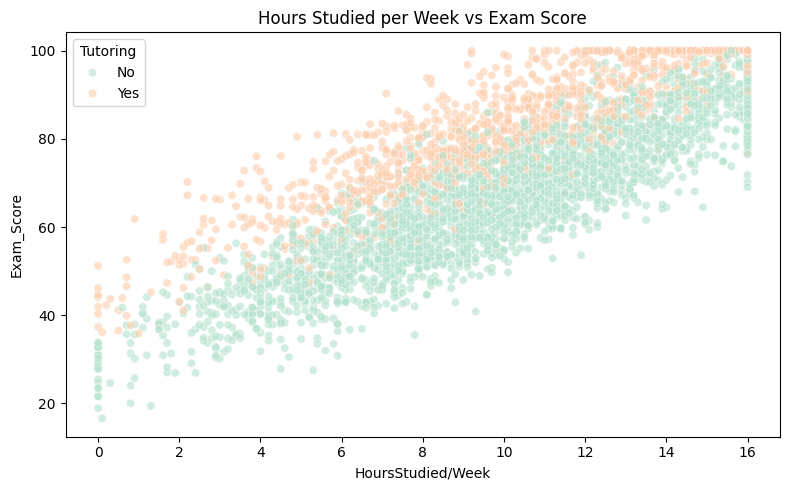

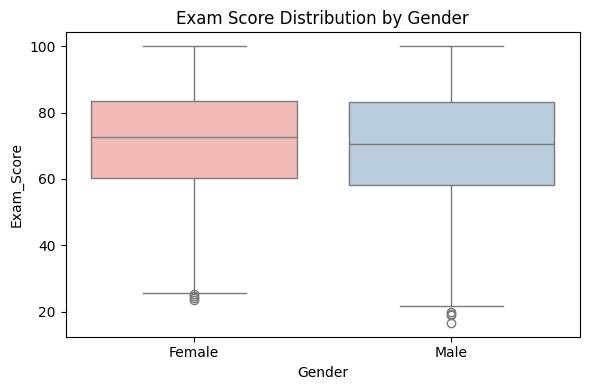

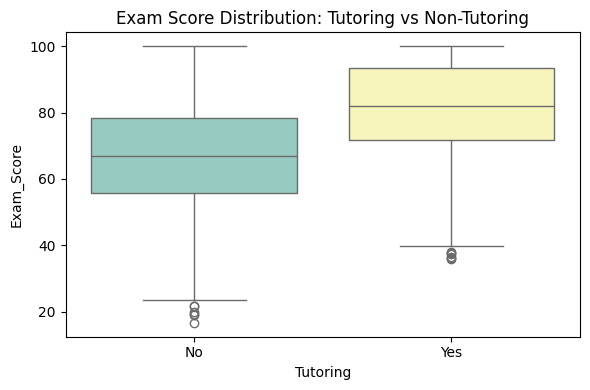

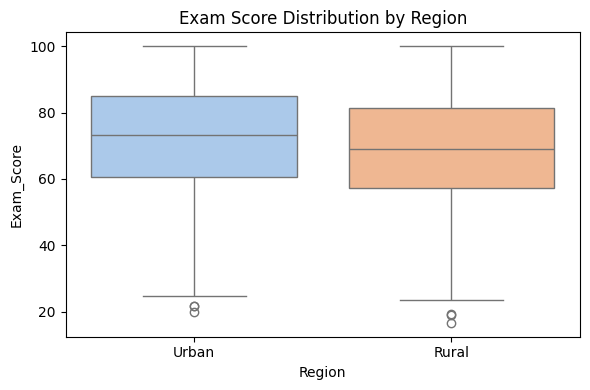

In [9]:
viz_df = df.copy()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=viz_df, x='HoursStudied/Week', y='Exam_Score', hue='Tutoring', alpha=0.6 ,palette='Pastel2')
plt.title('Hours Studied per Week vs Exam Score')
plt.tight_layout()
plt.show()

viz_df['Gender'] = pd.Categorical(viz_df['Gender'], categories=['Female', 'Male'], ordered=True)
plt.figure(figsize=(6, 4))
sns.boxplot(data=viz_df, x='Gender', y='Exam_Score', hue='Gender', legend=False, palette='Pastel1')
plt.title('Exam Score Distribution by Gender')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=viz_df, x='Tutoring', y='Exam_Score', palette='Set3',hue='Tutoring',legend=False)
plt.title('Exam Score Distribution: Tutoring vs Non-Tutoring')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=viz_df, x='Region', y='Exam_Score', palette='pastel',hue='Region',legend=False)
plt.title('Exam Score Distribution by Region')
plt.tight_layout()
plt.show()
